### 1. Import

In [1]:
cd c:\Users\nlinl\Desktop\Important\EECS6892\project\soccer_twos

c:\Users\nlinl\Desktop\Important\EECS6892\project\soccer_twos


c:\Users\nlinl\anaconda3\envs\rl\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# import packages
import time
import os
import torch
from torch import nn
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
from mlagents_envs.environment import UnityEnvironment as UE

In [3]:
# import modules
from environment import SoccerTwosEnvWrapper
from agents.dqn import DeepQN
from models.models import *

In [4]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### 2. Initialization

In [5]:
# in case set up fails
try:
    ue.close()
except:
    pass

In [6]:
# start up environment
root = r'C:/Users/nlinl/Desktop/Important/EECS6892/project/ml-agents/training-envs-executables'
ue = UE(file_name = root + '/' +'SoccerTwos.exe')
env = SoccerTwosEnvWrapper(ue)

### 3. Deep Q-Learning

#### Training

AGENT 0, EPISODE 1, FRAME 1000, GENERATION 0: last reward = 0.09, running reward =  0.09, episode time = 0.06, total time = 99.71
AGENT 1, EPISODE 1, FRAME 1000, GENERATION 0: last reward = 0.09, running reward =  0.09, episode time = 0.06, total time = 99.71
AGENT 2, EPISODE 1, FRAME 1000, GENERATION 0: last reward = -1.00, running reward =  -1.00, episode time = 0.06, total time = 99.71
AGENT 3, EPISODE 1, FRAME 1000, GENERATION 0: last reward = -1.00, running reward =  -1.00, episode time = 0.07, total time = 99.71
########################################
AGENT 0, EPISODE 7, FRAME 2000, GENERATION 0: last reward = 0.00, running reward =  -0.05, episode time = 8.69, total time = 199.54
AGENT 1, EPISODE 7, FRAME 2000, GENERATION 0: last reward = 0.00, running reward =  -0.05, episode time = 8.69, total time = 199.55
AGENT 2, EPISODE 7, FRAME 2000, GENERATION 0: last reward = 0.00, running reward =  -0.43, episode time = 8.69, total time = 199.55
AGENT 3, EPISODE 7, FRAME 2000, GENERAT

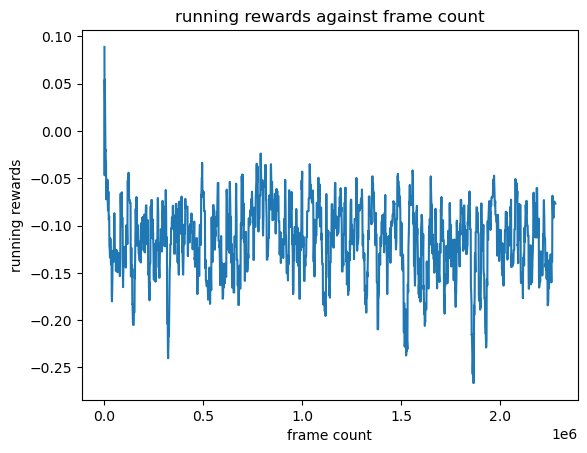

plot saved at /plots/dqn_training_plot.png


<Figure size 640x480 with 0 Axes>

In [8]:
"""
training DQN models
"""
#TODO: CHANGE ACTION TO JUST BE DECISION VALUES FOR THE 3 DIRECTIONS (this way it makes it easier to compute q values)
# IDEA: output a (9,) tensor -> reshape to (3,3) -> choose actions by taking argmax of dim = 0 ->  
# OR: figure out how to work out a way to match the q values from the target to the q values for the model
# init training parameters
gamma = 0.99 # discount factor
update_after_actions = 256 # number of actions per model update
target_update_after_actions = 1000 # number of actions per target model update
update_generation_after_episodes = 100
MAX_EPISODES = 50000 # number of episodes
MAX_STEPS_PER_EPISODE = 1000 # number of steps per episode
target_reward = 0.8 # desired reward for model
epsilon = np.linspace(1, 0.001, MAX_EPISODES) # TODO: modify this to another epsilon scheme?
learning_rate = 0.0005 # model learning rate
batch_size = 128 # training batch size
gamma = 0.99 # rewards discount factor
penalty = 0.0 # episode done penalty
max_memory = 10000 # maximum experience replay memory
last_n_reward = 100 # last n rewards considered for running rewards 

# init agents
num_agents = env.num_agents
agents = [DeepQN(
    model = LinearModel,
    in_size = env.obssize,
    out_size = env.actsize,
    learning_rate = learning_rate,
    batch_size = batch_size,
    gamma = gamma,
    penalty = penalty,
    max_memory = max_memory,
    last_n_reward = last_n_reward
) for _ in range(num_agents)]

# training loop
action_count = 0 # track number of steps passed during training
start_time = time.time()
target_met = False
generation_count = 0

try:

    for episode in range(MAX_EPISODES):

        states = np.array(env.reset())
        episode_start = time.time()

        for timestep in range(1, MAX_STEPS_PER_EPISODE):

            action_count += 1

            actions = [None] * num_agents
            
            # choosing action
            for a in range(num_agents):

                # get agent
                agent = agents[a]

                # epsilon-exploration
                if np.random.rand() < epsilon[episode]:
                    action = env.get_random_action(a)
                else:
                    state_t = torch.tensor(states[a])
                    state_t = torch.unsqueeze(state_t, 0)
                    action = agent.sample_action_from_policy(state_t)

                actions[a] = action

            # set action in environment
            for a, action in enumerate(actions):
                
                env.set_action(a, action)
            
            # take step in environment
            next_states, rewards, dones = env.step()

            # update replay history buffers
            for a in range(num_agents):
                
                # get agent
                agent = agents[a]
                
                # get transition
                state = states[a]
                action = actions[a] 
                next_state = np.array(next_states[a])
                reward = rewards[a]
                done = dones[a]
                
                # update agent replay buffer
                agent.update_replay_history(state, action, next_state, reward, done)

            states = next_states

            # updating models of each agent
            if action_count % update_after_actions == 0:

                for agent in agents:

                    # update model
                    agent.update()

            # updating target models
            if action_count % target_update_after_actions == 0:

                for a in range(num_agents):

                    # get agent
                    agent = agents[a]

                    # update target models
                    agent.update_target()

                    # print progress
                    episode_end = time.time()
                    agent.print_training_progress(a, action_count, generation_count, episode_end - episode_start, episode_end - start_time)

                    # update running rewards
                    agent.update_running_rewards()
                
                print( '#'*150)
            
            # trim replay buffer
            for agent in agents:
                agent.trim_reward_history()
            
            # end episode
            if done:
                break

        # save episode rewards
        for agent in agents:

            agent.update_episode_reward()


        # get best performing agent of current episode
        best_running_reward = -float('inf')
        best_agent = None
        for agent in agents:
            
            rr = agent.get_running_reward()
            if rr > best_running_reward:
                best_running_reward = rr
                best_agent = agent

        # check if target reward has been met by any agent
        if episode > 100 and best_running_reward > target_reward:
            print('target reward met')
            break

        # update models to the current best performing instance
        if episode > 0 and episode % update_generation_after_episodes == 0:            
            # set agent's base and target models to the best model
            for agent in agents:

                if agent == best_agent: continue

                agent.update_generation(best_agent)

            generation_count += 1

        # save best model weights
        log_episode = int(np.log10(episode)) if episode > 0 else 0
        # determine the increment of episodes bw each save
        save_increment = 10**log_episode
        if save_increment > 1 and episode % save_increment == 0:                
            best_agent.save_model(f'best_{episode}')

except KeyboardInterrupt:
    
    pass

# close environment
env.close()


# get best agent
if not target_met:

    best_rr = -float('inf')
    best_agent = None

    for agent in agents:

        rr = agent.get_running_reward()
        if rr > best_rr:
            best_rr = rr
            best_agent = agent

# save best agent's weights
print(f"saving best agent: running reward = {best_rr}")
best_agent.save_model('last')

# plot training results of bet agent
best_agent.plot_running_rewards(target_update_after_actions)

#### Testing
(Run initialization again)

In [9]:
TEST_EPISODES = 100
episode_rewards = []
num_agents = env.num_agents
path_to_weights = './weights/dqn_best_3000.pt'
 
num_agents = env.num_agents
agents = [DeepQN(
    model = LinearModel,
    in_size = env.obssize,
    out_size = env.actsize,
) for _ in range(num_agents)]

# load model
for agent in agents:
    agent.model.load_state_dict(torch.load(path_to_weights))

for episode in range(TEST_EPISODES):

    states = np.array(env.reset())
    done = False
    episode_reward = [0]*num_agents

    while not done:
    
        # choosing action
        actions = [None] * num_agents

        for a in range(num_agents):

            # get agent
            agent = agents[a]
            
            state_t = torch.tensor(states[a])
            state_t = torch.unsqueeze(state_t, 0)
            action = agent.sample_action_from_policy(state_t)

            actions[a] = action

        # set action in environment
        for a, action in enumerate(actions):
            
            env.set_action(a, action)

        # take step in environment
        next_states, rewards, dones = env.step()
        
        # update rewards
        for a in range(num_agents):
            episode_reward[a] += rewards[a]

        # state transition 
        states = next_states
        done = np.all(dones)

    episode_rewards.append(episode_reward)
    
    # print progress
    for a, agent in enumerate(agents):
        agent.print_testing_progrees(a, episode, episode_reward[a])
    print( '#'*40)


# plot test rewards
plt.plot(np.arange(1, TEST_EPISODES+1, 1), episode_rewards)
plt.title('episode rewards against episode count')
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend()
plt.show()
plt.savefig('./plots/dqn_testing_plot.png')
print('plot saved at /plots/dqn_testing_plot.png') 
  

AGENT 0, EPISODE 0: reward -1.00
AGENT 1, EPISODE 0: reward -1.00
AGENT 2, EPISODE 0: reward 0.58
AGENT 3, EPISODE 0: reward 0.58
########################################
AGENT 0, EPISODE 1: reward -1.00
AGENT 1, EPISODE 1: reward -1.00
AGENT 2, EPISODE 1: reward 0.56
AGENT 3, EPISODE 1: reward 0.56
########################################


KeyboardInterrupt: 